# Amazon Fine Food Reviews Sentiment Analysis

* Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews
* EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/

* Credits: www.appliedaicourse.com

The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.

* Number of reviews: 568,454
* Number of users: 256,059
* Number of products: 74,258
* Timespan: Oct 1999 - Oct 2012
* Number of Attributes/Columns in data: 10

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (Rating of 4 or 5) or negative (rating of 1 or 2).

## Loading the data
The dataset is available in two forms

1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it easier to query the data and visualise the data efficiently.

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score id above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
!pip install -U gensim

Requirement already up-to-date: gensim in c:\users\ravia\anaconda3\lib\site-packages (3.8.3)


In [53]:
import sklearn
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets, neighbors
import seaborn as sns
import sqlite3 
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.random_projection import sparse_random_matrix
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_val_score,train_test_split,TimeSeriesSplit,GridSearchCV,RandomizedSearchCV
import scikitplot.metrics as skplt
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer
import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm 

# [1]. Reading Data

In [3]:
# using the SQLite Table to read data.
con = sqlite3.connect("database.sqlite")
#filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con)

In [4]:
def filter_score(x):
    if x<3:
        return 0
    return 1

actual_score = filtered_data["Score"]
positiveNegative = actual_score.map(filter_score)
filtered_data["Score"] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (500000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


#  Exploratory Data Analysis

## [2] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [5]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
ORDER BY COUNT(*) DESC
""", con)

In [6]:
print(display.shape)
display[display["COUNT(*)"]<10]

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
7590,AZXYMD0WNZVLE,B002N7DSLG,Chrissy B,1243209600,5,"These are excellent. Expensive, but so good. Y...",9
7591,AZWC23X2AZAQC,B003VXFK44,M. C. Bowman,1294704000,3,"With so many choices now, I thought I woudl gi...",9
7592,AZU591T4LP32O,B0013NUGDE,"mousey gray ""classic everything fan""",1297036800,5,I really love these but hope they would lower ...,9
7593,AZSVQQ6XTN4Y2,B0013NUGDE,Gail S.,1317254400,5,I order Pop Chips through Amazon as none of my...,9
7594,AZRI5QQD2M4ZK,B005C3IVN8,SteveKeys,1350604800,5,I've had quite a few different Grade B maple s...,9
...,...,...,...,...,...,...,...
80663,#oc-R15343ZW0UTLMR,B007TGDXNO,"Lisa L. Nolen ""SimplyLisaLisa""",1346457600,1,"I shouldn't label myself a coffee connoisseur,...",2
80664,#oc-R13EBF129DBX88,B005ZBZLT4,mary,1344729600,2,This coffee is not what I expected. I thought...,2
80665,#oc-R12KPBODL2B5ZD,B007OSBEV0,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2
80666,#oc-R11DNU2NBKQ23Z,B005ZBZLT4,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2


In [7]:
display["COUNT(*)"].sum()

393063

In [8]:
display = pd.read_sql_query("""
SELECT * FROM Reviews
WHERE SCORE != 3 AND UserId="AZXYMD0WNZVLE" ORDER BY ProductId """,con)
display.head(10)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,311611,B000EVG8H4,AZXYMD0WNZVLE,Chrissy B,1,1,4,1235779200,Yum!,"I am recently gluten-free, and first tried Bob..."
1,165267,B000EVG8J2,AZXYMD0WNZVLE,Chrissy B,0,0,5,1243209600,Excellent,"These are excellent. Expensive, but so good. Y..."
2,439159,B000EVKHQM,AZXYMD0WNZVLE,Chrissy B,0,0,5,1243209600,Excellent,"These are excellent. Expensive, but so good. Y..."
3,312982,B000FPFC4E,AZXYMD0WNZVLE,Chrissy B,0,0,4,1234051200,Yum!,I just got put on a gluten and peanut-free die...
4,100742,B002N7DSLG,AZXYMD0WNZVLE,Chrissy B,0,0,5,1243209600,Excellent,"These are excellent. Expensive, but so good. Y..."
5,518094,B002N7DSNE,AZXYMD0WNZVLE,Chrissy B,0,0,5,1243209600,Excellent,"These are excellent. Expensive, but so good. Y..."
6,395653,B002N7DSP2,AZXYMD0WNZVLE,Chrissy B,0,0,5,1243209600,Excellent,"These are excellent. Expensive, but so good. Y..."
7,477279,B002N7OCGQ,AZXYMD0WNZVLE,Chrissy B,0,0,5,1243209600,Excellent,"These are excellent. Expensive, but so good. Y..."


In [9]:
#Sorting data according to ProductId in ascending order
sorted_data = filtered_data.sort_values('ProductId',axis=0,ascending=True,inplace=False,kind='quicksort',na_position='last')

In [10]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(348262, 10)

In [11]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.6524

**Observation:-** It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [12]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [13]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [14]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(348260, 10)


1    293516
0     54744
Name: Score, dtype: int64

# [3].  Text Preprocessing.

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [15]:
# printing some random reviews
sent_0 = final['Text'].values[3]
print(sent_0)
print("="*50)
sent_1000 = final['Text'].values[1003]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1503]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4903]
print(sent_4900)
print("="*50)

TITLE: Chicken Soup with Rice<br />AUTHOR: Maurice Sendak<br />REVIEWER: Josh Grossman, Colonel {r}, U.S.A.R., M.C., M.D., FACP<br />Rural physician/author/educator-Mentor U.S.M.L.E. Step 3...<br />>Who would believe that I have memorized this book?<br />>Who would believe that I can recite any month in any order?<br />>Who would believe that I read my copy to tatters while reading to my children now professional adults?<br />>Who would believe that my grandchildren read their copy to tatters?<br />I can be confident that generations of children will enjoy "Chicken Soup with Rice"<br />Bravo!<br />Thank you!<br />Respectfully submitted...
After years of using Starbuck's decaf and regular single serving espresso pods, I finally found a substitute that's more economical and MUCH better tasting.<p>I've used three different brands of pods in my Starbuck's Barista machine, and have found that the quality of the pod and the flavor of the espresso inside is, by far, the best in the Espression

In [16]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

TITLE: Chicken Soup with Rice<br />AUTHOR: Maurice Sendak<br />REVIEWER: Josh Grossman, Colonel {r}, U.S.A.R., M.C., M.D., FACP<br />Rural physician/author/educator-Mentor U.S.M.L.E. Step 3...<br />>Who would believe that I have memorized this book?<br />>Who would believe that I can recite any month in any order?<br />>Who would believe that I read my copy to tatters while reading to my children now professional adults?<br />>Who would believe that my grandchildren read their copy to tatters?<br />I can be confident that generations of children will enjoy "Chicken Soup with Rice"<br />Bravo!<br />Thank you!<br />Respectfully submitted...


In [17]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

TITLE: Chicken Soup with RiceAUTHOR: Maurice SendakREVIEWER: Josh Grossman, Colonel {r}, U.S.A.R., M.C., M.D., FACPRural physician/author/educator-Mentor U.S.M.L.E. Step 3...>Who would believe that I have memorized this book?>Who would believe that I can recite any month in any order?>Who would believe that I read my copy to tatters while reading to my children now professional adults?>Who would believe that my grandchildren read their copy to tatters?I can be confident that generations of children will enjoy "Chicken Soup with Rice"Bravo!Thank you!Respectfully submitted...
After years of using Starbuck's decaf and regular single serving espresso pods, I finally found a substitute that's more economical and MUCH better tasting.I've used three different brands of pods in my Starbuck's Barista machine, and have found that the quality of the pod and the flavor of the espresso inside is, by far, the best in the Espressione pods. The flavor is more full bodied and stronger than in the Starb

In [18]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [19]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

I was so ecstatic when I purchased two 44lb bags of canidae dog food.  We have used this food for years and my dogs love it. They have  beautiful coats. On  August 15, 2011 for 41.99 each with free shipping from amazon. The actual shipper was Petcare RX. Since I am feeding 4 large dogs (including a rescue) we go through a lot of food. Its nice to have it delivered to your door. I just signed on to reorder and noticed that amazon increased the price from $41.99 to $55. In theory, there goes free shipping. They rolled it into the new cost of the food. Now, it is no cheaper for me to purchase it on amazon since my neighborhood pet store sells it for $54.00 and I do not have to order it 7-10 days ahead just to make sure I get it before our current supply runs out. SHAME ON YOU AMAZON!


In [20]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [21]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    #remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    #remove spacial character: https://stackoverflow.com/a/5843547/4084039
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|████████████████████████████████████████████████████████████████████████| 348260/348260 [05:17<00:00, 1095.32it/s]


In [22]:
preprocessed_reviews[1500]

'great product healthy dogs first food love eat helped older dog lose weight year old lab gain weight needed healthy'

<h2>[3.2] Preprocess Summary</h2>

In [25]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews_summary = []
# tqdm is for printing the status bar
for sentance in tqdm(final["Summary"].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    #remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    #remove spacial character: https://stackoverflow.com/a/5843547/4084039
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews_summary.append(sentance.strip())

100%|████████████████████████████████████████████████████████████████████████| 348260/348260 [03:03<00:00, 1897.37it/s]


## merging summary and reviews text

In [36]:
final_list=[]
n=0
while n<len(preprocessed_reviews_summary):
    final_list.append(preprocessed_reviews_summary[n]+" "+preprocessed_reviews[n])
    n+=1

In [40]:
print(preprocessed_reviews_summary[0])
print(preprocessed_reviews[0])

great gift
book purchased birthday gift year old boy squealed delight hugged told keep not return library


In [38]:
print(final_list[0])

great gift book purchased birthday gift year old boy squealed delight hugged told keep not return library


In [41]:
final["Score"]

138702    1
138707    1
138708    0
138692    1
138689    1
         ..
178141    1
173675    1
204727    1
5259      1
302474    1
Name: Score, Length: 348260, dtype: int64

In [43]:
# https://stackoverflow.com/questions/25149667/save-a-python-list-in-sqlite
#Saved File For Future Use No need to perform text_preprocessing multiple times
df = pd.DataFrame({'Reviews_preprocessed':final_list ,'positive_review': final["Score"]})
df.to_csv("final_preprocess_reviews_with_lables.csv",index=False)

# [4] Featurization

In [3]:
df=pd.read_csv("final_preprocess_reviews_with_lables.csv",index_col=False)
df.head()

,Reviews_preprocessed,positive_review
0,great gift book purchased birthday gift year o...,1
1,december snowman anniversary daughter loves re...,1
2,awesome book poor size one best children books...,0
3,professional mentoring title chicken soup rice...,1
4,chicken soup rice months fun way children lear...,1


### [4.1]Word Tokenization

* Converting the sentences into list of words through **nltk library 'tokenizer' class**


In [6]:
import nltk
# nltk.download("punkt")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ravia\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [19]:
words=[]
for sent in df["Reviews_preprocessed"][:2]:
    words.append(nltk.word_tokenize(sent))

## Stemming and Lemmmatization

* Process of reducing infected words to their stem word is called **Stemming** gives not a meaningful word (history ==> histori,historical ==> histori) used for **sentiment analysis**
* Process of reducing infected words to their stem word is called **Lemmatization** gives a meaningful word (history ==> history, historical ==> history) used for **chatbot** user will interact with it

In [ ]:
#Stemming
words=[]
for sent in df["Reviews_preprocessed"][:2]:
    words.append(nltk.word_tokenize(sent))

In [34]:
from nltk.stem.porter import PorterStemmer
stemmer = PorterStemmer()
print(stemmer.stem("historical"))
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english",ignore_stopwords=False)
print(stemmer.stem("having"))

histor
having


## Spliting Data

* Spliting Data into train, test data to avoid **Data leakage** problem
* **Data leakage** refers to a mistake make by the creator of a machine learning model in which they accidentally share information between the test and training data-sets. Typically, when splitting a data-set into testing and training sets, the goal is to ensure that no data is shared between the two.

In [57]:
from sklearn.model_selection import train_test_split
Xtrain,Xtest,ytrain,ytest = train_test_split(df["Reviews_preprocessed"],df["positive_review"])
# Xtrain,Xcv,ytrain,ycv = train_test_split(Xtrain,ytrain)


In [58]:
print(Xtrain.shape)
# print(Xcv.shape)

(261195,)


## [4.1] BAG OF WORDS

In [59]:
count_vect = CountVectorizer()
train_bow=count_vect.fit_transform(Xtrain)
test_bow=count_vect.transform(Xtest)
# cv_bow=count_vect.transform(Xcv)

In [60]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler(with_mean=False)
train_std_bow=scaler.fit_transform(train_bow)
test_std_bow=scaler.transform(test_bow)
# cv_std_bow=scaler.transform(cv_bow)

## Metrics:
* https://towardsdatascience.com/accuracy-recall-precision-f-score-specificity-which-to-optimize-on-867d3f11124
* True positive (TP): Prediction is +ve and X is diabetic, we want that
* True negative (TN): Prediction is -ve and X is healthy, we want that too
* False positive (FP): Prediction is +ve and X is healthy, false alarm, bad
* False negative (FN): Prediction is -ve and X is diabetic, the worst

## Cross Validation and Hyperparameter tuning using Logistic regression Custom Function

* Splitted cross validation data from train data for hyper parameter tuning
* Accuracy is used when the True Positives and True negatives are more important while F1-score is used when the False Negatives and False Positives are crucial.
* In most real-life classification problems, 
* imbalanced class distribution exists and thus F1-score is a better metric to evaluate our model on
* F-1 score is used since data is imbalanced 

In [54]:
def optimal_cv(X_train,y_train,X_test,y_test):
        from sklearn.metrics import f1_score
        myList = [0.00001,0.0001,0.001,0.01,0.1,1,10,100]
        cv_scores = []
        non_zero=[]

        for C in myList:
            logi=LogisticRegression(C=C,class_weight='balanced')
            logi.fit(X_train,y_train)
            y_pred=logi.predict(X_test)
            scores=f1_score(y_test,y_pred,average='micro')
            cv_scores.append(scores)
        
        MSE = [1 - x for x in cv_scores]

    # determining best C
        optimal_c = myList[MSE.index(min(MSE))]
        print('\nThe optimal C is %3f.' % optimal_c)
        plt.plot(myList, MSE)


        plt.xlabel('C Value')
        plt.ylabel('Misclassification Error')
        plt.show()

        print("the misclassification error for each C value is : ", np.round(MSE,3))
    
        return optimal_c


The optimal C is 0.000100.


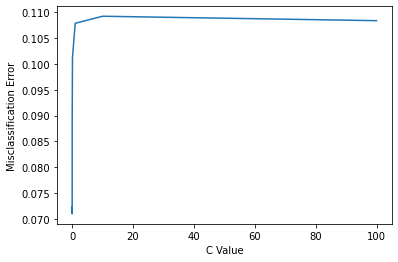

the misclassification error for each C value is :  [0.072 0.071 0.077 0.089 0.101 0.108 0.109 0.108]


In [55]:
optimal_c_bow=optimal_cv(train_std_bow,ytrain,cv_std_bow,ycv)

## Cross Validation and Hyperparameter tuning using Logistic regression Grid Search CV

* always it is better to use GridSearchCv, RandomSearchCv rather than using custom function gives more accurate parameters

In [61]:
tuned_parameters = [{'C': [10**-4,10**-3, 10**-2,10**-1, 10**0,10, 10**2,10**3, 10**4]}]

#Using GridSearchCV
model = GridSearchCV(LogisticRegression(), tuned_parameters, scoring = 'f1', cv=5,n_jobs=-1)
model.fit(train_std_bow, ytrain)
print(model.best_estimator_)

LogisticRegression(C=0.001)


In [63]:
optimal_C_bow=model.best_params_["C"]
print("Best C using GridSearch CV %1.4f"%optimal_C_bow)
print("Train Accuracy using GridSearch CV %1.3f"%model.best_score_)

Best C using GridSearch CV 0.0010
Train Accuracy using GridSearch CV 0.960


In [65]:
ypred=model.predict(test_std_bow)

In [66]:
from sklearn.metrics import classification_report
print(classification_report(ytest, ypred, target_names=["positive","negative"]))


              precision    recall  f1-score   support

    positive       0.81      0.73      0.77     13497
    negative       0.95      0.97      0.96     73568

    accuracy                           0.93     87065
   macro avg       0.88      0.85      0.86     87065
weighted avg       0.93      0.93      0.93     87065



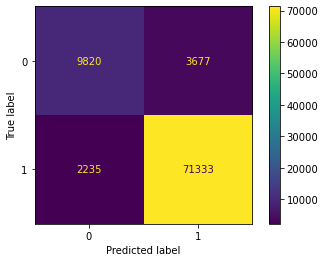

In [68]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(model, test_std_bow, ytest)
plt.show()

* False Positive Rate a bit higher than the false negative rate 